In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.applications import VGG19
from skimage.transform import resize
from tensorflow.python.keras.utils import np_utils
import cv2
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd 
import zipfile

## Load data

#### Extract files from zip file

In [2]:
!kaggle datasets download -d alxmamaev/flowers-recognition

Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
License(s): unknown
flowers-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
zip_ref = zipfile.ZipFile('flowers-recognition.zip', 'r')
zip_ref.extractall('unzipped_folder') # unzip directory
zip_ref.close()

In [4]:
# base_path = 'Dataset/flowers/'
base_path = 'unzipped_folder/flowers/'
categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

#### Load file names

In [5]:
fnames = []
for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

In [6]:
print('length for each category:', [len(f) for f in fnames])

length for each category: [764, 1052, 784, 733, 984]


#### Load images

In [7]:
# train, test = train_test_split(fnames[0], train_size=0.8)
images = []
for names in fnames:
    one_category_images = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
    images.append(one_category_images)

In [8]:
print('number of images for each category:', [len(f) for f in images])

number of images for each category: [764, 1052, 784, 733, 984]


#### Calculate the minimal shape for all images

In [9]:
for i,imgs in enumerate(images):
    shapes = [img.shape for img in imgs]
    widths = [shape[0] for shape in shapes]
    heights = [shape[1] for shape in shapes]
    print('%d,%d is the min shape for %s' % (np.min(widths), np.min(heights), categories[i]))

134,134 is the min shape for daisy
98,134 is the min shape for dandelion
80,150 is the min shape for rose
134,152 is the min shape for sunflower
134,134 is the min shape for tulip


#### Create a function to convert cv2 BGR format to RGB for showing

In [10]:
def cvtRGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

#### Show sample images for all flowers

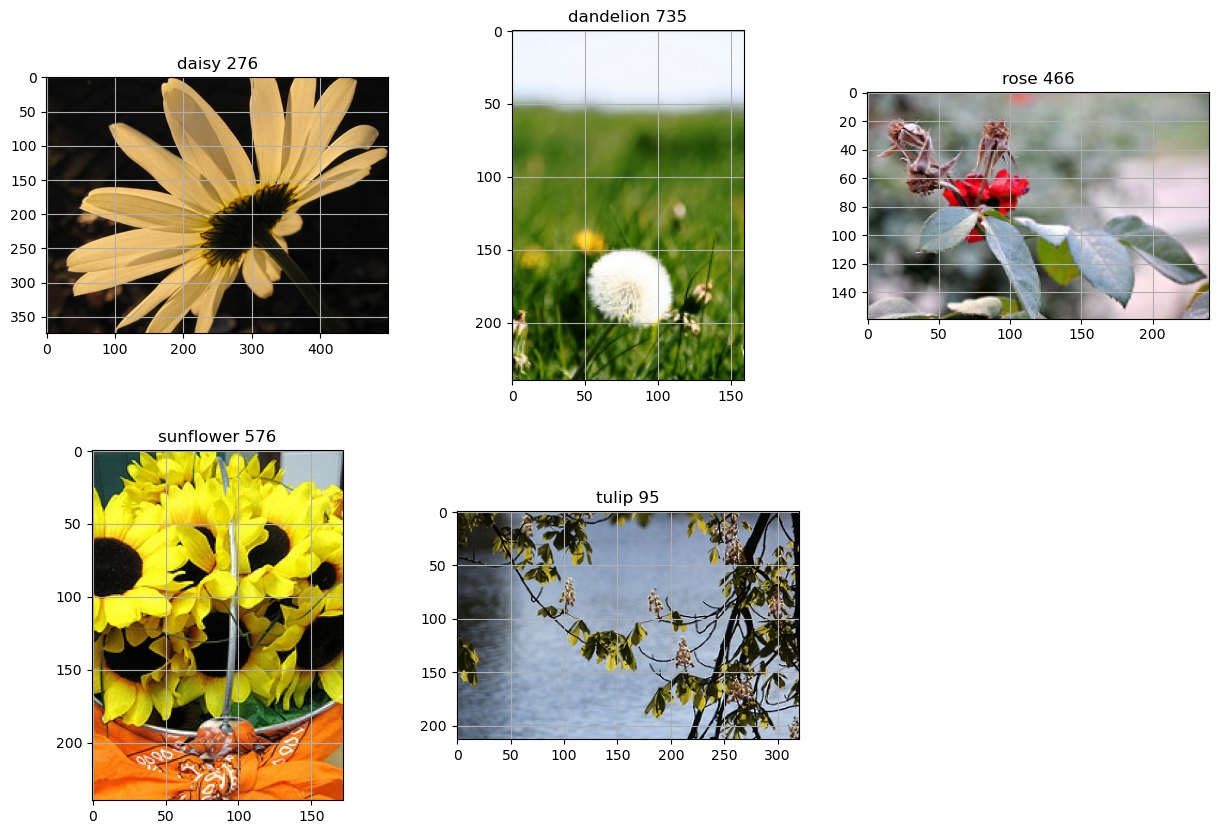

In [11]:
plt.figure(figsize=(15,10))
for i, imgs in enumerate(images):
    plt.subplot(2,3,i+1)
    idx = np.random.randint(len(imgs))
    plt.imshow(cvtRGB(imgs[idx]))
    plt.grid('off')
    plt.title(categories[i]+' '+str(idx))
plt.show()

#### Resize all the images to 224x224

(257, 500, 3)
(224, 224, 3)


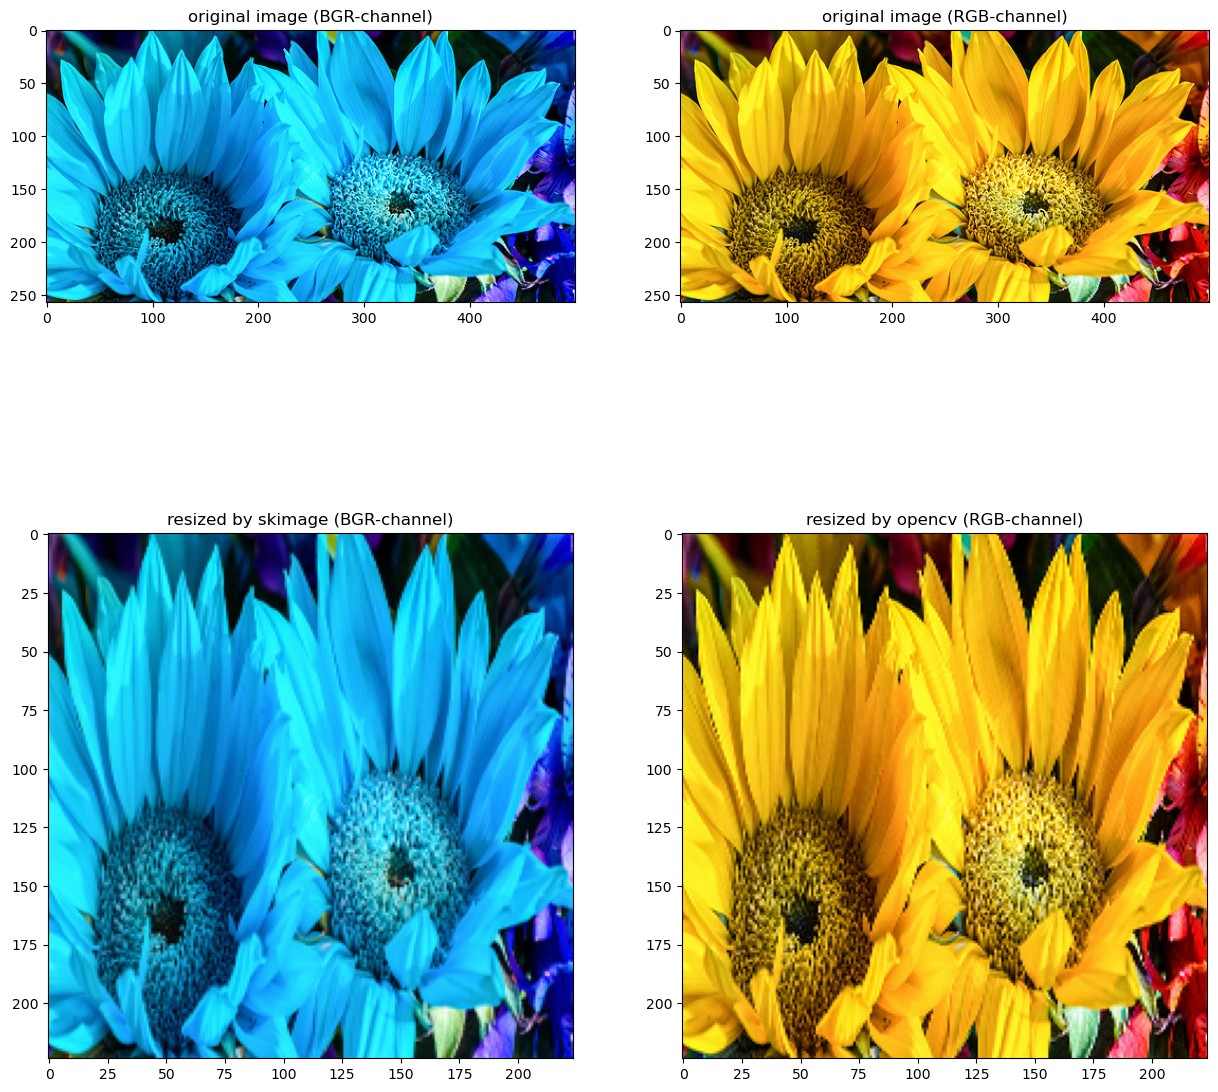

In [12]:
img_width, img_height = 224, 224

img = images[3][659]
print(img.shape)
resized_img = resize(img, (img_width, img_height, 3))
resized_img2 = cv2.resize(img,(img_width, img_height), interpolation = cv2.INTER_CUBIC)
print(resized_img.shape)
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title('original image (BGR-channel)')
plt.grid(False)
plt.imshow(img)
plt.subplot(2,2,2)
plt.title('original image (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(img))
plt.subplot(2,2,3)
plt.title('resized by skimage (BGR-channel)')
plt.grid(False)
plt.imshow((resized_img))
plt.subplot(2,2,4)
plt.title('resized by opencv (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(resized_img2))
plt.show()

In [13]:
# Apply resize to all images
resized_images = []
for i,imgs in enumerate(images):
    resized_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])

#### Split dataset to 80% of training and 20% of validation 

In [14]:
train_images = []
val_images = []
for imgs in resized_images:
    train, test = train_test_split(imgs, train_size=0.8, test_size=0.2)
    train_images.append(train)
    val_images.append(test)

#### Create labels

In [15]:
len_train_images = [len(imgs) for imgs in train_images]
print(len_train_images)
print('sum of train images:', np.sum(len_train_images))
train_categories = np.zeros((np.sum(len_train_images)), dtype='uint8')
for i in range(5):
    if i == 0:
        train_categories[:len_train_images[i]] = i
    else:
        train_categories[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i
        
len_val_images = [len(imgs) for imgs in val_images]
print(len_val_images)
print('sum of val_images:', np.sum(len_val_images))
val_categories = np.zeros((np.sum(len_val_images)), dtype='uint8')
for i in range(5):
    if i == 0:
        val_categories[:len_val_images[i]] = i
    else:
        val_categories[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])] = i

[611, 841, 627, 586, 787]
sum of train images: 3452
[153, 211, 157, 147, 197]
sum of val_images: 865


#### Convert image data to numpy array
Convert and pre-processing

convert class labels to binary class labels

In [16]:
tmp_train_imgs = []
tmp_val_imgs = []
for imgs in train_images:
    tmp_train_imgs += imgs
for imgs in val_images:
    tmp_val_imgs += imgs
train_images = np.array(tmp_train_imgs)
val_images = np.array(tmp_val_imgs)

In [17]:
print('Before converting')
print('train data:', train_images.shape)
print('train labels:', train_categories.shape)

train_data = train_images.astype('float32')
val_data = val_images.astype('float32')
train_data = train_data / 255
val_data = val_data / 255
train_labels = np_utils.to_categorical(train_categories, len(categories))
val_labels = np_utils.to_categorical(val_categories, len(categories))
print()
print('After converting')
print('train data:', train_data.shape)
print('train labels:', train_labels.shape)

Before converting
train data: (3452, 224, 224, 3)
train labels: (3452,)

After converting
train data: (3452, 224, 224, 3)
train labels: (3452, 5)


#### Shuffle the dataset (set a seed and randomize both the data and the labels)

In [18]:
seed = 100
np.random.seed(seed)
np.random.shuffle(train_data)
np.random.seed(seed)
np.random.shuffle(train_labels)
np.random.seed(seed)
np.random.shuffle(val_data)
np.random.seed(seed)
np.random.shuffle(val_labels)

In [19]:
train_data = train_data[:3400]
train_labels = train_labels[:3400]
val_data = val_data[:860]
val_labels = val_labels[:860]
print('shape of train data:', train_data.shape)
print('shape of train labels:', train_labels.shape)
print('shape of val data:', val_data.shape)
print('shape of val labels:', val_labels.shape)

shape of train data: (3400, 224, 224, 3)
shape of train labels: (3400, 5)
shape of val data: (860, 224, 224, 3)
shape of val labels: (860, 5)


#### Hardware Detection

In [20]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


#### Training the model

In [21]:
with strategy.scope():
    pre_trained_model = VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:19]:
        layer.trainable = False

    model = Sequential([
        pre_trained_model,
        MaxPool2D((2,2) , strides = 2),
        Flatten(),
        Dense(1024, activation="relu"),
        Dropout(0.5),
        Dense(512, activation="relu"),
        Dense(5 , activation='softmax')])
    model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['acc'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ ?                           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 4,719,616 (18.00 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

In [22]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [23]:
history = model.fit(train_data, train_labels, batch_size = 64 , epochs = 12 , validation_data = (val_data, val_labels),callbacks = [learning_rate_reduction])

Epoch 1/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 386s 7s/step - acc: 0.3479 - loss: 1.7586 - val_acc: 0.5221 - val_loss: 1.1485 - learning_rate: 0.0010
Epoch 2/12


D:\Anaconda\Lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: acc,loss,val_acc,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 380s 7s/step - acc: 0.5348 - loss: 1.0934 - val_acc: 0.6593 - val_loss: 0.8621 - learning_rate: 0.0010
Epoch 3/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 375s 7s/step - acc: 0.6748 - loss: 0.8225 - val_acc: 0.6791 - val_loss: 0.8667 - learning_rate: 0.0010
Epoch 4/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 375s 7s/step - acc: 0.7372 - loss: 0.6781 - val_acc: 0.7372 - val_loss: 0.7603 - learning_rate: 0.0010
Epoch 5/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 374s 7s/step - acc: 0.7894 - loss: 0.5519 - val_acc: 0.6849 - val_loss: 0.8844 - learning_rate: 0.0010
Epoch 6/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 373s 7s/step - acc: 0.7977 - loss: 0.5412 - val_acc: 0.7267 - val_loss: 0.7722 - learning_rate: 0.0010
Epoch 7/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 373s 7s/step - acc: 0.8496 - loss: 0.4111 - val_acc: 0.7674 - val_loss: 0.7788 - learning_rate: 0.0010
Epoch 8/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 372s 7s/step - acc: 0.8766 - loss: 0.3582 - val_acc: 0.7523 - val_loss: 0.7003 - learning_rate: 0.0010
Epoch 9/12
54/54 ━━━━━━━

In [24]:
print("Loss of the model is - " , model.evaluate(val_data,val_labels)[0])
print("Accuracy of the model is - " , model.evaluate(val_data,val_labels)[1]*100 , "%")

27/27 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - acc: 0.7407 - loss: 1.0371
Loss of the model is -  0.9993175268173218
27/27 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - acc: 0.7407 - loss: 1.0371
Accuracy of the model is -  75.23255944252014 %


#### Analysis after model training

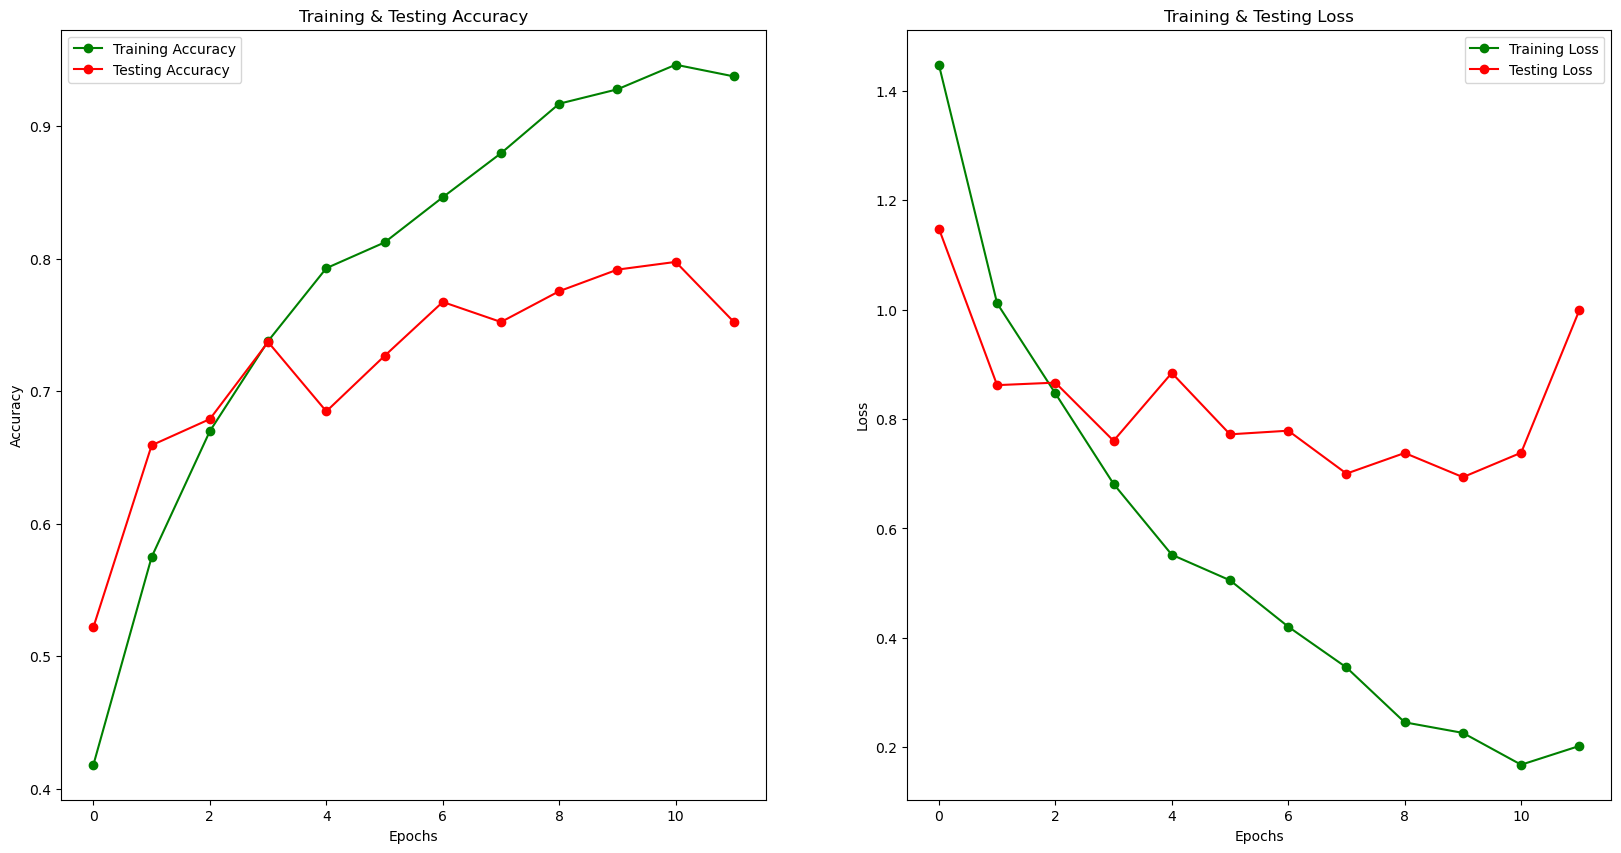

In [25]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [26]:
predictions = model.predict(val_data)

27/27 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step


In [27]:
rounded_predictions = np.array([np.round(i) for i in predictions])
rounded_predictions = rounded_predictions.astype(np.int64)

In [28]:
from numpy import argmax
y_test_inv = [argmax(y, axis=None, out=None) for y in val_labels]
print(classification_report(val_labels, rounded_predictions, target_names = categories))

              precision    recall  f1-score   support

       daisy       0.93      0.75      0.83       152
   dandelion       0.94      0.69      0.80       211
        rose       0.66      0.69      0.67       156
   sunflower       0.77      0.69      0.72       147
       tulip       0.69      0.88      0.77       194

   micro avg       0.78      0.74      0.76       860
   macro avg       0.79      0.74      0.76       860
weighted avg       0.80      0.74      0.76       860
 samples avg       0.74      0.74      0.74       860



D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Axes: >

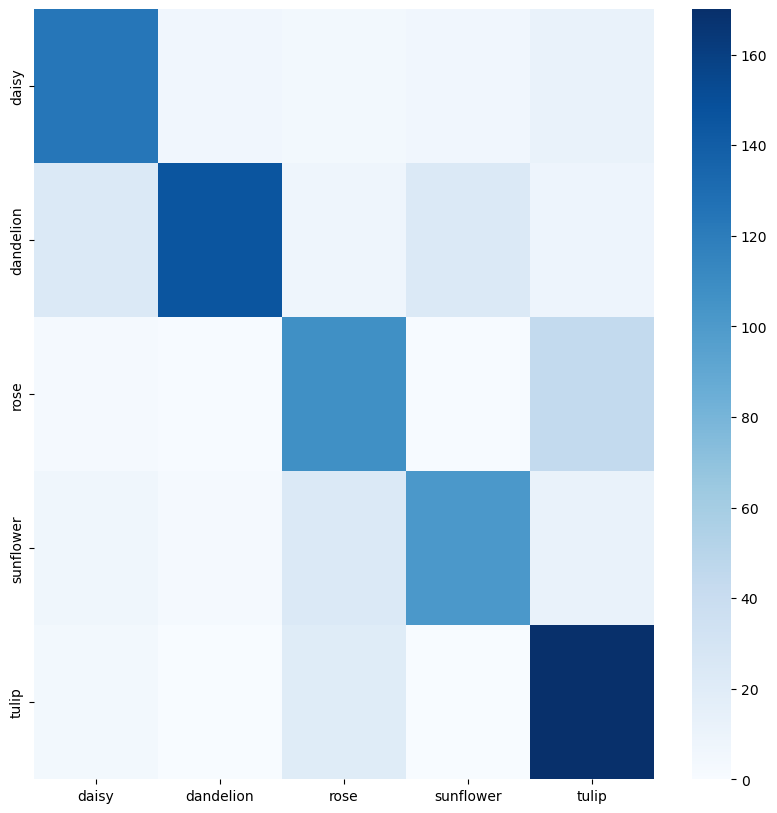

In [29]:
cm = confusion_matrix(val_labels.argmax(axis=1), rounded_predictions.argmax(axis=1))
cm = pd.DataFrame(cm, index = categories, columns = categories)

plt.figure(figsize = (10,10))
sns.heatmap(cm, cmap= "Blues", fmt='' , xticklabels = categories, yticklabels = categories)

In [30]:
cm

daisy  dandelion  rose  sunflower  tulip
daisy        124          6     4          6     12
dandelion     24        146     8         24      9
rose           3          1   107          1     44
sunflower      7          3    24        101     12
tulip          4          0    20          0    170

In [31]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(val_labels)):
    if((val_labels[i] == rounded_predictions[i]).all()):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(val_labels)):
    if((val_labels[i] != rounded_predictions[i]).any()):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

#### Correctly Classified Flower Images

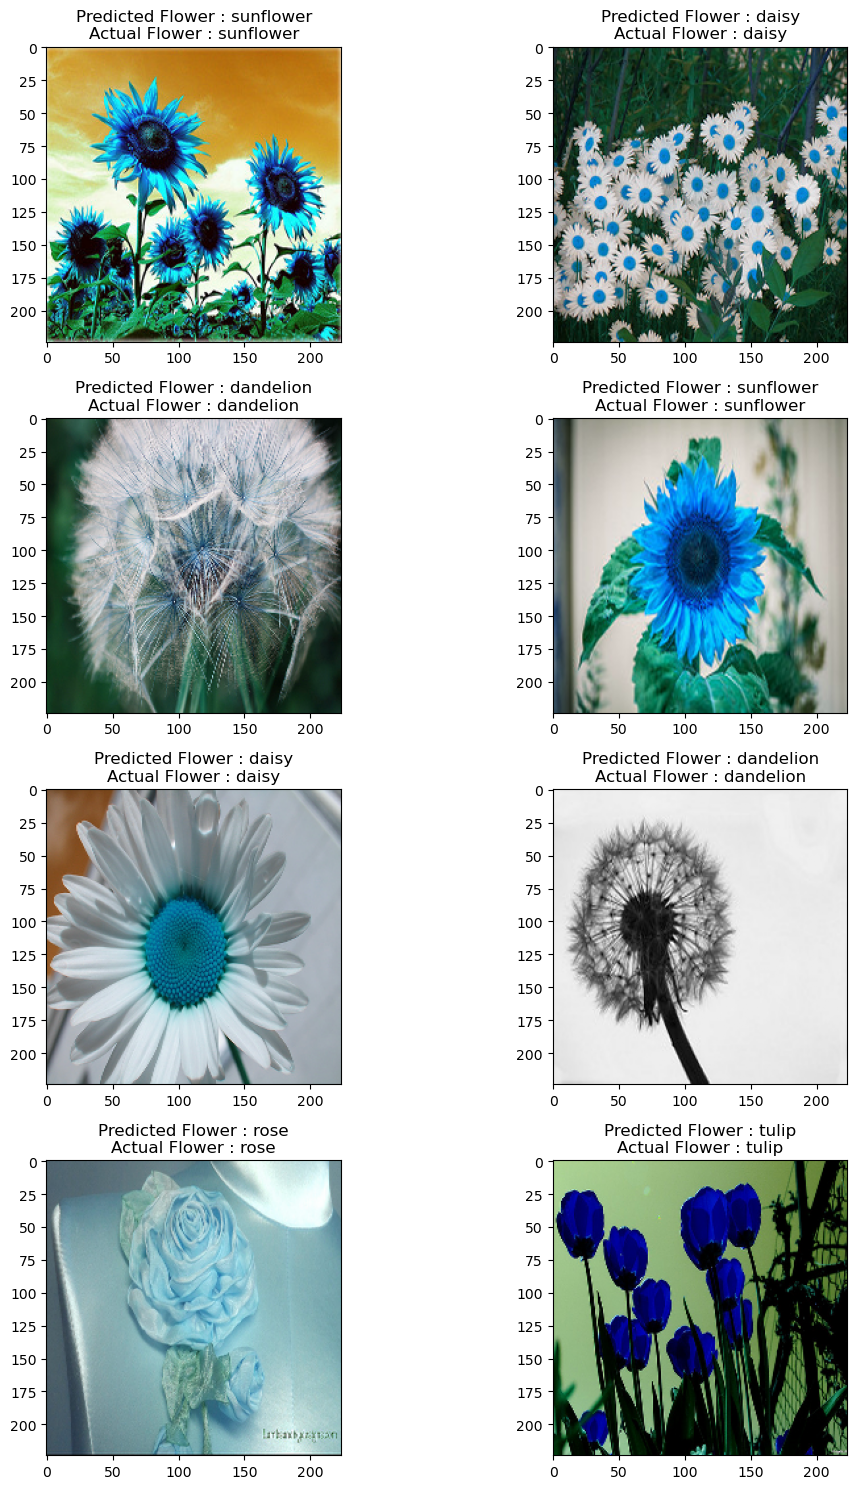

In [32]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(val_data[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+ categories[np.argmax(rounded_predictions[prop_class[count]])] +"\n"+"Actual Flower : "+ categories[np.argmax(val_labels[prop_class[count]])])
        plt.tight_layout()
        count+=1

#### Incorrectly Classified Flower Images

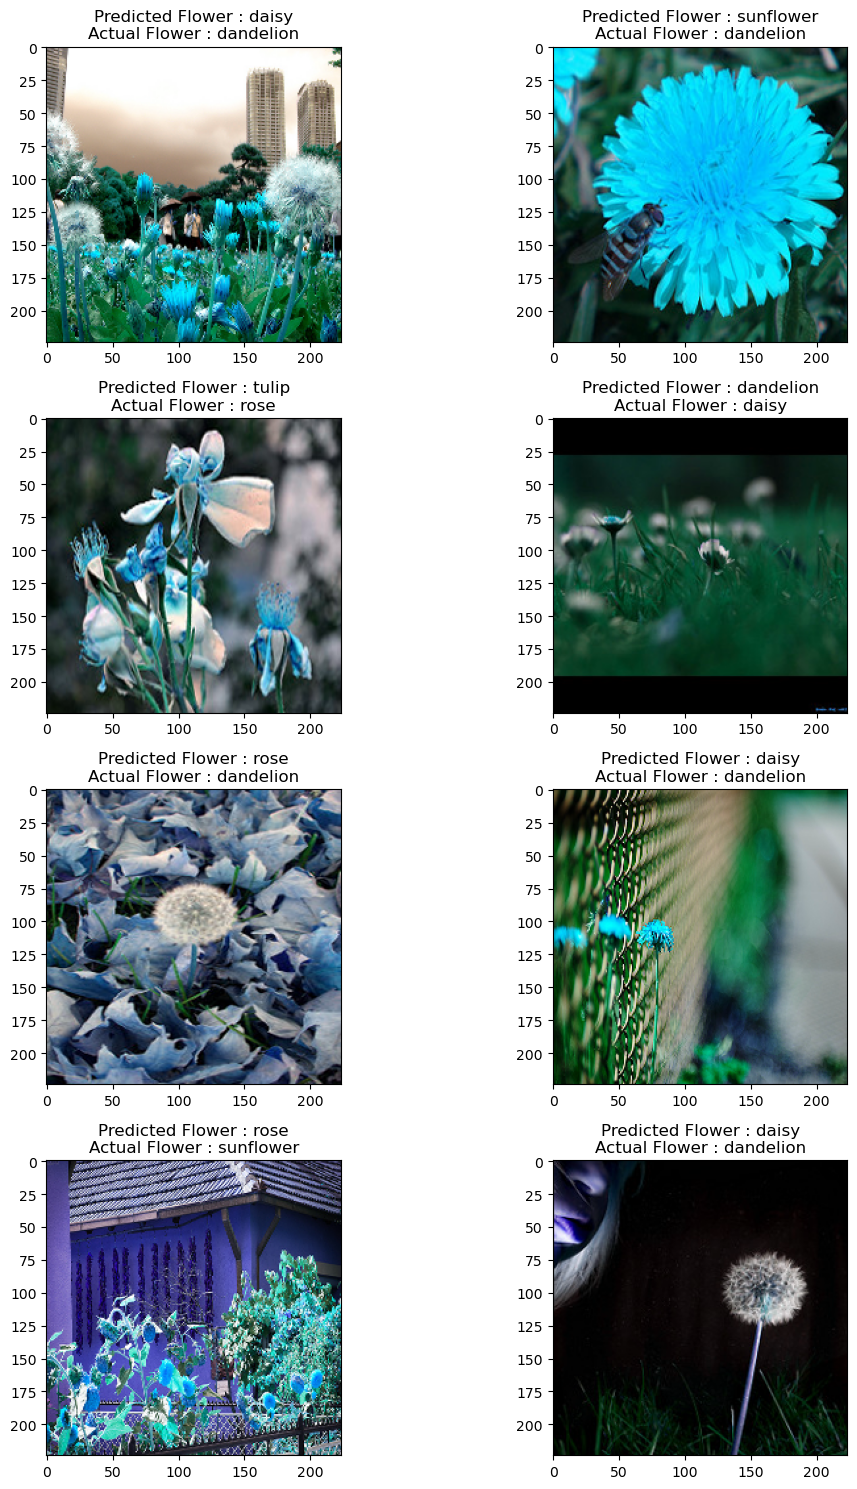

In [33]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(val_data[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+categories[np.argmax(rounded_predictions[mis_class[count]])]+"\n"+"Actual Flower : "+categories[np.argmax(val_labels[mis_class[count]])])
        plt.tight_layout()
        count+=1

In [61]:
model.save('Flower_Recog_Model.keras')